# Data and Models
In the subsequent lessons, we will continue to learn deep learning. But we've ignored a fundamental concept about data and modeling: quality and quantity.

<div align="left">
<a href="https://github.com/madewithml/basics/blob/master/notebooks/10_Data_and_Models/10_PT_Data_and_Models.ipynb" role="button"><img class="notebook-badge-image" src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/madewithml/basics/blob/master/notebooks/10_Data_and_Models/10_PT_Data_and_Models.ipynb"><img class="notebook-badge-image" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

In a nutshell, a machine learning model consumes input data and produces predictions. The quality of the predictions directly corresponds to the quality and quantity of data you train the model with; **garbage in, garbage out**. Check out this [article](https://venturebeat.com/2018/06/30/understanding-the-practical-applications-of-business-ai/) on where it makes sense to use AI and how to properly apply it.

We're going to go through all the concepts with concrete code examples and some synthesized data to train our models on. The task is to determine whether a tumor will be benign (harmless) or malignant (harmful) based on leukocyte (white blood cells) count and blood pressure. This is a synethic dataset that we created and has no clinical relevance.

# Full dataset

We'll first train a model with the entire dataset. Later we'll remove a subset of the dataset and see the effect it has on our model.

## Data

### Load data

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import urllib

In [0]:
SEED = 1234
DATA_FILE = 'tumors.csv'

In [0]:
# Set seed for reproducibility
np.random.seed(SEED)

In [0]:
# Load data from GitHub to this notebook's local drive
url = "https://raw.githubusercontent.com/madewithml/basics/master/data/tumors.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(DATA_FILE, 'wb') as fp:
    fp.write(html)

In [6]:
# Raw data
df = pd.read_csv(DATA_FILE, header=0)
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,13.472969,15.250393,malignant
1,10.805510,14.109676,malignant
2,13.834053,15.793920,malignant
3,9.572811,17.873286,malignant
4,7.633667,16.598559,malignant


In [0]:
# Define X and y
X = df[['leukocyte_count', 'blood_pressure']].values
y = df['tumor_class'].values

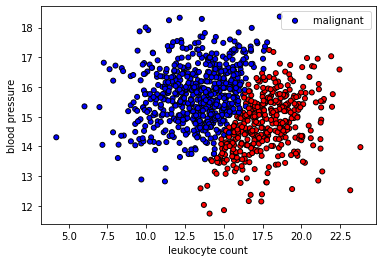

In [8]:
# Plot data
colors = {'benign': 'red', 'malignant': 'blue'}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], s=25, edgecolors='k')
plt.xlabel('leukocyte count')
plt.ylabel('blood pressure')
plt.legend(['malignant ', 'benign'], loc="upper right")
plt.show()

We want to choose features that have strong predictive signal for our task. If you want to improve performance, you need to continuously do feature engineering by collecting and adding new signals. So you may run into a new feature that has high correlation (orthogonal signal) with your existing features but it may still possess some unique signal to boost your predictive performance. 

,leukocyte_count,blood_pressure
leukocyte_count,1.000000,-0.162875
blood_pressure,-0.162875,1.000000


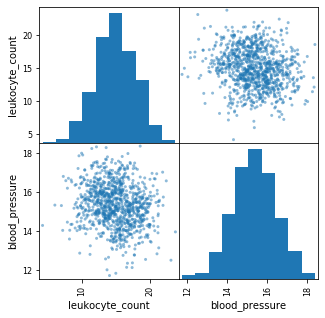

In [9]:
# Correlation matrix
scatter_matrix(df, figsize=(5, 5));
df.corr()

### Split data

In [0]:
import collections
from sklearn.model_selection import train_test_split

In [0]:
TRAIN_SIZE = 0.70
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SHUFFLE = True

In [0]:
def train_val_test_split(X, y, val_size, test_size, shuffle):
    """Split data into train/val/test datasets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, stratify=y_train, shuffle=shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [13]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
class_counts = dict(collections.Counter(y))
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")
print (f"Classes: {class_counts}")

X_train: (722, 2), y_train: (722,)
X_val: (128, 2), y_val: (128,)
X_test: (150, 2), y_test: (150,)
Sample point: [18.01865938 15.48133647] → benign
Classes: {'malignant': 611, 'benign': 389}


### Label encoder

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
# Output vectorizer
y_tokenizer = LabelEncoder()

In [16]:
# Fit on train data
y_tokenizer = y_tokenizer.fit(y_train)
classes = list(y_tokenizer.classes_)
print (f"classes: {classes}")

classes: ['benign', 'malignant']


In [17]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = y_tokenizer.transform(y_train)
y_val = y_tokenizer.transform(y_val)
y_test = y_tokenizer.transform(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: benign
y_train[0]: 0


In [18]:
# Class weights
counts = collections.Counter(y_train)
class_weights = {_class: 1.0/count for _class, count in counts.items()}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: Counter({1: 441, 0: 281}),
class weights: {0: 0.0035587188612099642, 1: 0.0022675736961451248}


### Standardize data

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

In [0]:
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [22]:
# Check (means should be ~0 and std should be ~1)
print (f"X_train[0]: mean: {np.mean(X_train[:, 0], axis=0):.1f}, std: {np.std(X_train[:, 0], axis=0):.1f}")
print (f"X_train[1]: mean: {np.mean(X_train[:, 1], axis=0):.1f}, std: {np.std(X_train[:, 1], axis=0):.1f}")
print (f"X_val[0]: mean: {np.mean(X_val[:, 0], axis=0):.1f}, std: {np.std(X_val[:, 0], axis=0):.1f}")
print (f"X_val[1]: mean: {np.mean(X_val[:, 1], axis=0):.1f}, std: {np.std(X_val[:, 1], axis=0):.1f}")
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_train[0]: mean: 0.0, std: 1.0
X_train[1]: mean: -0.0, std: 1.0
X_val[0]: mean: 0.1, std: 1.0
X_val[1]: mean: 0.1, std: 1.0
X_test[0]: mean: -0.1, std: 1.0
X_test[1]: mean: -0.1, std: 1.0


## Modeling

In [0]:
import torch

In [24]:
# Set seed for reproducibility
torch.manual_seed(SEED)

### Model

In [0]:
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

In [0]:
INPUT_DIM = 2 # X is 2-dimensional
HIDDEN_DIM = 100
NUM_CLASSES = 2

In [0]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in)) # ReLU activaton function added!
        y_pred = self.fc2(z)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1) 
        return y_pred

In [28]:
# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)
summary(model, input_size=(INPUT_DIM,))

<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]             300
            Linear-2                    [-1, 2]             202
Total params: 502
Trainable params: 502
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Training

In [0]:
from torch.optim import Adam

In [0]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5
BATCH_SIZE = 32

In [0]:
# Loss
weights = torch.Tensor([class_weights[key] for key in sorted(class_weights.keys())])
loss_fn = nn.CrossEntropyLoss(weight=weights)

In [0]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

In [0]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 

In [0]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [37]:
# Training
for epoch in range(NUM_EPOCHS*10):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0: 
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 0.70, accuracy: 48.8
Epoch: 10 | loss: 0.55, accuracy: 91.7
Epoch: 20 | loss: 0.43, accuracy: 97.6
Epoch: 30 | loss: 0.36, accuracy: 98.2
Epoch: 40 | loss: 0.30, accuracy: 98.2


### Evaluation

In [0]:
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [0]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [40]:
# Predictions
pred_train = model(X_train, apply_softmax=True)
pred_test = model(X_test, apply_softmax=True)
print (f"sample probability: {pred_test[0]}")
pred_train = pred_train.max(dim=1)[1]
pred_test = pred_test.max(dim=1)[1]
print (f"sample class: {pred_test[0]}")

sample probability: tensor([0.3269, 0.6731], grad_fn=<SelectBackward>)
sample class: 1


In [41]:
# Accuracy
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.98, test acc: 0.94


We're going to plot a white point, which we know belongs to the malignant tumor class. Our well trained model here would accurately predict that it is indeed a malignant tumor!

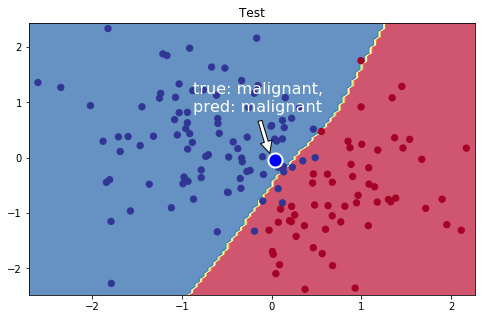

In [42]:
# Visualize the decision boundary
plt.figure(figsize=(8,5))
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)

# Sample point near the decision boundary
mean_leukocyte_count, mean_blood_pressure = X_scaler.transform(
    [[np.mean(df.leukocyte_count), np.mean(df.blood_pressure)]])[0]
plt.scatter(mean_leukocyte_count+0.05, mean_blood_pressure-0.05, s=200, 
            c='b', edgecolor='w', linewidth=2)

# Annotate
plt.annotate('true: malignant,\npred: malignant',
             color='white',
             xy=(mean_leukocyte_count, mean_blood_pressure),
             xytext=(0.4, 0.65),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='white', shrink=0.1))
plt.show()

Great! We received great performances on both our train and test data splits. We're going to use this dataset to show the importance of data quality and quantity.

# Reduced dataset

Let's remove some training data near the decision boundary and see how robust the model is now.

## Data

### Load data

In [0]:
REDUCED_DATA_FILE = 'tumors_reduced.csv'

In [0]:
# Load data from GitHub to this notebook's local drive
url = "https://raw.githubusercontent.com/madewithml/basics/master/data/tumors_reduced.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(REDUCED_DATA_FILE, 'wb') as fp:
    fp.write(html)

In [45]:
# Raw reduced data
df_reduced = pd.read_csv(REDUCED_DATA_FILE, header=0)
df_reduced.head()

,leukocyte_count,blood_pressure,tumor_class
0,13.472969,15.250393,malignant
1,10.805510,14.109676,malignant
2,13.834053,15.793920,malignant
3,9.572811,17.873286,malignant
4,7.633667,16.598559,malignant


In [0]:
# Define X and y
X = df_reduced[['leukocyte_count', 'blood_pressure']].values
y = df_reduced['tumor_class'].values

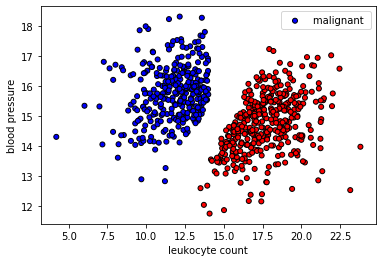

In [47]:
# Plot data
colors = {'benign': 'red', 'malignant': 'blue'}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], s=25, edgecolors='k')
plt.xlabel('leukocyte count')
plt.ylabel('blood pressure')
plt.legend(['malignant ', 'benign'], loc="upper right")
plt.show()

### Split data

In [48]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X, y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
class_counts = dict(collections.Counter(y_train))
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")
print (f"Classes: {class_counts}")

X_train: (520, 2), y_train: (520,)
X_val: (92, 2), y_val: (92,)
X_test: (108, 2), y_test: (108,)
Sample point: [14.4110029  13.14842457] → benign
Classes: {'benign': 281, 'malignant': 239}


### Label encoder

In [0]:
# Encode class labels
y_tokenizer = LabelEncoder()
y_tokenizer = y_tokenizer.fit(y_train)
num_classes = len(y_tokenizer.classes_)
y_train = y_tokenizer.transform(y_train)
y_val = y_tokenizer.transform(y_val)
y_test = y_tokenizer.transform(y_test)

In [50]:
# Class weights
counts = collections.Counter(y_train)
class_weights = {_class: 1.0/count for _class, count in counts.items()}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: Counter({0: 281, 1: 239}),
class weights: {0: 0.0035587188612099642, 1: 0.0041841004184100415}


### Standardize data

In [0]:
# Standardize inputs using training data
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

## Modeling

### Model

In [0]:
# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)

### Training

In [0]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 

In [0]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [55]:
# Training
for epoch in range(NUM_EPOCHS*10):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0: 
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 0.70, accuracy: 49.6
Epoch: 10 | loss: 0.54, accuracy: 88.7
Epoch: 20 | loss: 0.42, accuracy: 97.3
Epoch: 30 | loss: 0.34, accuracy: 99.6
Epoch: 40 | loss: 0.27, accuracy: 100.0


### Evaluation

In [56]:
# Predictions
pred_train = model(X_train, apply_softmax=True)
pred_test = model(X_test, apply_softmax=True)
print (f"sample probability: {pred_test[0]}")
pred_train = pred_train.max(dim=1)[1]
pred_test = pred_test.max(dim=1)[1]
print (f"sample class: {pred_test[0]}")

sample probability: tensor([0.9436, 0.0564], grad_fn=<SelectBackward>)
sample class: 0


In [57]:
# Accuracy
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 1.00, test acc: 1.00


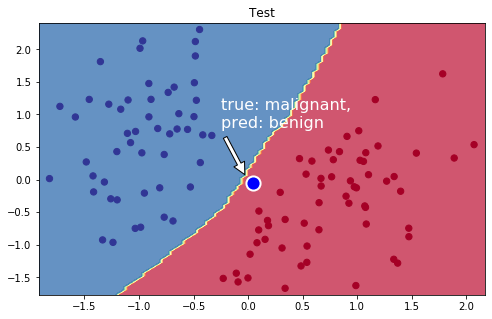

In [58]:
# Visualize the decision boundary
plt.figure(figsize=(8,5))
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)

# Sample point near the decision boundary (same point as before)
plt.scatter(mean_leukocyte_count+0.05, mean_blood_pressure-0.05, s=200, 
            c='b', edgecolor='w', linewidth=2)

# Annotate
plt.annotate('true: malignant,\npred: benign',
             color='white',
             xy=(mean_leukocyte_count, mean_blood_pressure),
             xytext=(0.45, 0.60),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='white', shrink=0.1))
plt.show()

This is a very scary but highly realistic scenario. Based on our reduced synthetic dataset, we have achieved a model that generalized really well on the test data. But when we ask for the prediction for the same point tested earlier (which we known is malignant), the prediction is now a benign tumor. We would have completely missed the tumor. To mitigate this, we can:
1. Get more data around the space we are concerned about
2. Consume predictions with caution when they are close to the decision boundary

# Takeaway

Models are not crystal balls. So it's important that before any machine learning, we really look at our data and ask ourselves if it is truly representative for the task we want to solve. The model itself may fit really well and generalize well on your data but if the data is of poor quality to begin with, the model cannot be trusted.

Once you are confident that your data is of good quality and quantity, you can finally start thinking about modeling. The type of model you choose depends on many factors, including the task, type of data, complexity required, etc. 

<div align="left">
<img src="https://raw.githubusercontent.com/madewithml/images/master/basics/10_Data_and_Models/models.png" width="500">
</div>

So once you figure out what type of model your task needs, start with simple models and then slowly add complexity. You don’t want to start with neural networks right away because that may not be right model for your data and task. Striking this balance in model complexity is one of the key tasks of your data scientists. **simple models → complex models**



---
Share and discover ML projects at <a href="https://madewithml.com/">Made With ML</a>.

<div align="left">
<a class="ai-header-badge" target="_blank" href="https://github.com/madewithml/basics"><img src="https://img.shields.io/github/stars/madewithml/basics.svg?style=social&label=Star"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://www.linkedin.com/company/madewithml"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://twitter.com/madewithml"><img src="https://img.shields.io/twitter/follow/madewithml.svg?label=Follow&style=social"></a>
</div>
             